In [113]:
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import numpy as np
import os

os.chdir("..")

linestyles = ["-", "--", ":"]

In [114]:
class ExpInfo:
    def __init__(self):
        pass
    
class ExpDB:
    def __init__(self, data=[], dir_path=None):
        assert data == [] or dir_path is None
        if dir_path is not None:
            self.data = []
            for path in Path(dir_path).glob("**/new_metrics_*.pkl"):
                self.add_from_path(path)
        else:
            self.data = data
    
    def add_from_path(self, path):
        name = path.stem
        mode, max_len, pred_size = path.parent.name.split("_")
        test_set_size, n_samples, T_pred = name.split("_")[-1].split("-")
        max_len, pred_size, test_set_size, n_samples, T_pred = map(int, [max_len, pred_size, test_set_size, n_samples, T_pred])
        config = dict(mode=mode, max_len=max_len, pred_size=pred_size,
                      test_set_size=test_set_size, n_samples=n_samples,
                      T_pred=T_pred)
        metrics = pickle.load(open(path, "rb"))
        self.data.append({"path": path,
                          "config": config,
                          "metrics": metrics})
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def __iter__(self):
        return iter(self.data)
    
    def query(self, **kwargs):
        return ExpDB([x for x in self.data if all([x["config"][k] == v for (k,v) in kwargs.items()])])

    def sort(self, keys):
        if isinstance(keys, str):
            self.sort([keys])
        self.data.sort(key=lambda x: [x["config"][k] for k in keys])
        
    def get_sorted(self, keys):
        if isinstance(keys, str):
            return self.get_sorted([keys])
        return ExpDB(data=sorted(self.data, key=lambda x: [x["config"][k] for k in keys]))
        
    def print_config(self):
        for x in self.data:
            print(x["config"])

In [115]:
# metrics_db.sort(["mode", "pred_size", "n_samples"])
metrics_db = ExpDB(dir_path='/home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion')
print(len(metrics_db))

13


In [116]:
metrics_db.print_config()

{'mode': 'autoreg', 'max_len': 20, 'pred_size': 10, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 264}
{'mode': 'independent', 'max_len': 10, 'pred_size': 5, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 264}
{'mode': 'mixed-autoreg-independent', 'max_len': 10, 'pred_size': 5, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 264}
{'mode': 'autoreg', 'max_len': 36, 'pred_size': 4, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 264}
{'mode': 'independent', 'max_len': 20, 'pred_size': 10, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 264}
{'mode': 'mixed-autoreg-independent', 'max_len': 20, 'pred_size': 10, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 264}
{'mode': 'independent', 'max_len': 10, 'pred_size': 5, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 264}
{'mode': 'mixed-autoreg-independent', 'max_len': 10, 'pred_size': 5, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 264}
{'mode': 'autoreg', 'max_len': 40, 'pred_size': 20, 'test_set_size': 112, 'n_samples': 2, 'T_pred':

In [117]:
_default_label_func = lambda x: f"{x['path'].parent.name}/{x['path'].stem}"


def do_plot(db, ax, mode, errorbar=True,
            label_func=_default_label_func,
            agg_mode="best",
            baseline_metrics=None, set_color=None):
    
    def agg_predictions(metric, agg_mode):
        assert agg_mode in ["best", "best_avg", "mean", "random"]
        best_fn = {"ssim": "max", "psnr": "max", "lpips": "min"}[mode]

        if agg_mode == "best":
            metric = getattr(metric, best_fn)(axis=1)
        elif agg_mode == "best_avg":
            # Finding the order within samples wrt avg metric across time.
            order_metric = np.argsort(np.mean(metric, -1), axis=-1)
            assert best_fn in ["max", "min"]
            if best_fn == "max":
                metric = np.stack([metric[i, order[-1]] for (i, order) in enumerate(order_metric)])
            else:
                metric = np.stack([metric[i, order[0]] for (i, order) in enumerate(order_metric)])
        elif agg_mode == "random":
            metric = metric[:, 0, :]
        elif agg_mode == "mean":
            metric = metric.mean(axis=1)
        else:
            raise ValueError(f"Unknown aggregation mode {agg_mode}")
        return metric
    
    assert mode in ["ssim", "psnr", "lpips"]
    if label_func is None:
        label_func = lambda x: None
    for exp_data in db:
        path = str(exp_data["path"])
        metrics = exp_data["metrics"]
        if mode not in metrics:
            print(f"Metrics {mode} not found in {path}")
            continue
        metric = agg_predictions(metrics[mode], agg_mode)

        mean = metric.mean(axis=0)
        std = metric.std(axis=0)
        label = None
        ls = '-'
        label = label_func(exp_data)
        
        color = set_color(path) if set_color is not None else None
        
        ax.plot(mean, label=label, color=color, ls=ls)
        if errorbar:
            ax.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1)
    ax.grid("on")    
        
# def plot_metrics(db, agg_mode="random", errorbar=False, label_func=_default_label_func,
#                  baseline_metrics=baseline_metrics):
#     fig, axes = plt.subplots(1,3, figsize=(6.4 * 3, 4.8))
#     axes[0].set_title("SSIM")
#     axes[1].set_title("PSNR")
#     axes[2].set_title("LPIPS")
#     colors_dict = {}
#     do_plot(db, ax=axes[0], mode="ssim", errorbar=errorbar, colors_dict=colors_dict,
#             label_func=label_func, agg_mode=agg_mode, baseline_metrics=baseline_metrics)
#     do_plot(db, ax=axes[1], mode="psnr", errorbar=errorbar, colors_dict=colors_dict,
#             label_func=label_func, agg_mode=agg_mode, baseline_metrics=baseline_metrics)
#     do_plot(db, ax=axes[2], mode="lpips", errorbar=errorbar, colors_dict=colors_dict,
#             label_func=label_func, agg_mode=agg_mode, baseline_metrics=baseline_metrics)
#     handles, labels = axes[0].get_legend_handles_labels()
#     fig.legend(handles, labels)
#     return fig, axes

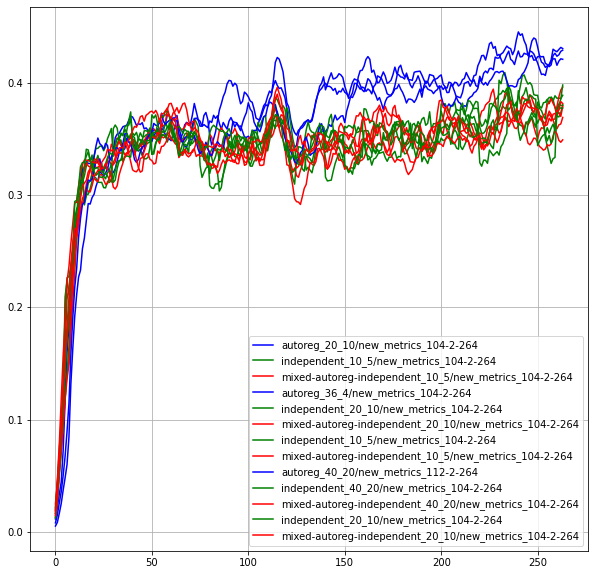

In [118]:
def set_color(path):
    if 'mixed' in path:
        return 'r'
    elif 'autoreg' in path:
        return 'b'
    elif 'independent' in path:
        return 'g'
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(metrics_db, ax, mode='lpips', errorbar=False, set_color=set_color)
ax.legend()

In [128]:
mixed_db = [thing for thing in metrics_db if 'mixed' in str(thing['path'])]
autoreg_db = [thing for thing in metrics_db if 'autoreg_' in str(thing['path']) and 'mixed' not in str(thing['path'])]
independent_db = [thing for thing in metrics_db if 'independent_' in str(thing['path']) and 'mixed' not in str(thing['path'])]

## Autoreg

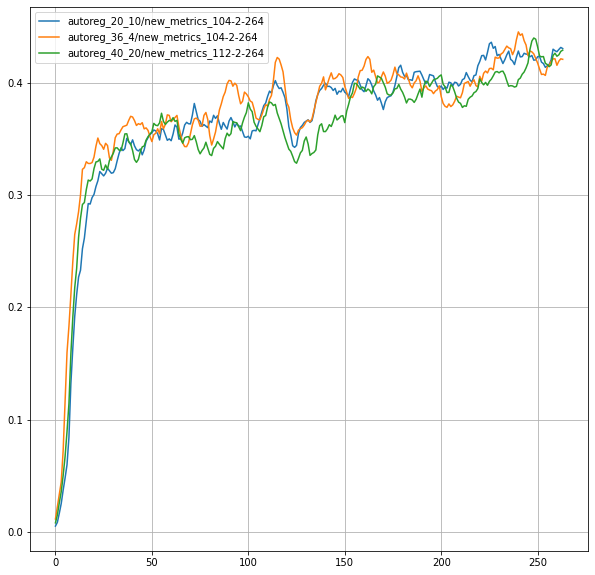

In [129]:
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(autoreg_db, ax, mode='lpips', errorbar=False, set_color=None)
ax.legend()

## Mixed

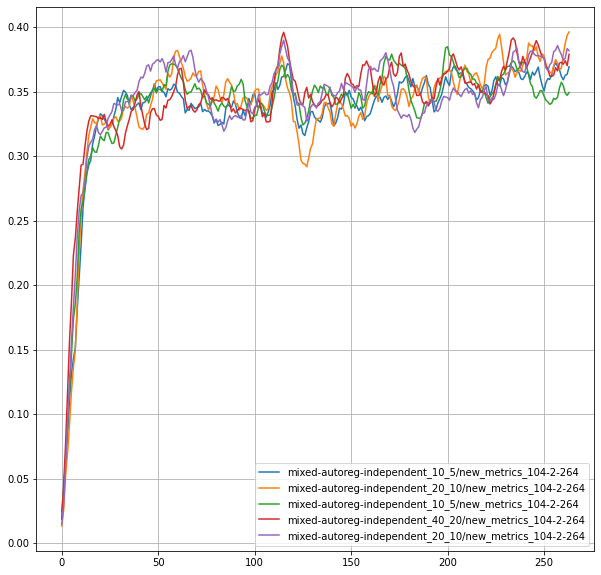

In [130]:
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(mixed_db, ax, mode='lpips', errorbar=False, set_color=None)
ax.legend()

## Independent

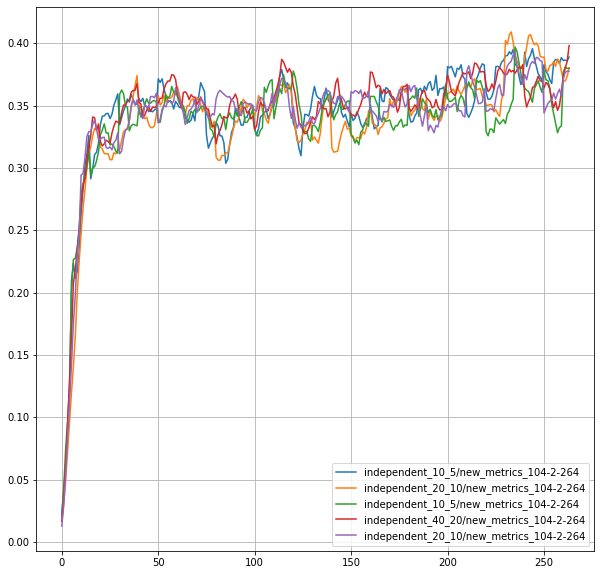

In [131]:
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(independent_db, ax, mode='lpips', errorbar=False, set_color=None)
ax.legend()